# Integration in higher dimensions

NB library functions:

`from scipy.integrate import dblquad, tplquad, nquad`

#### Example: 2D integrals over a rectangular domain

$$
I[f] = \int_0^{1}\!\int_0^{1}\! f(x, y)\, dy\, dx \;.
$$

Use a Gauss-Legendre quadrature (weight function $=1$) for both $x$ and $y$:

$$
Q[f] = \sum_{j=0}^{m} \sum_{k=0}^{n} f(x_j, y_k)\, w_j^{(x)} \, w_k^{(y)}
$$

#### Example: 2D integrals over a triangular domain

$$
\begin{aligned}
I[f] &= \int_0^1 \! \int_0^{\color{red}{x}} \! f(x, y) \, dy \, dx \qquad\text{change variables } y = tx \\
     &= \int_0^1 \! \int_0^{\color{red}{1}} \! f(x, t\color{red}{x})\, \color{red}{x}\, dt \, dx \\
     &= \int_0^1\! \left(\int_0^1\!f(x, tx)\, dt \right) x\,dx
\end{aligned}
$$


The weight in $t$ is still uniform, so use the Gauss-Legendgre quadrature in $t$. For $x$, http://dlmf.nist.gov/18.3 suggests using the Jacobi quadrature with $\alpha = 0$ and $\beta = 1$, after a change of variables $x = (1 + \xi) / 2$ with $\xi \in (-1, 1)$.

An issue with these sorts of tricks is that they do not easily generalize for non-trivial boundaries.

# Monte Carlo integration

## I. Buffon's needle: compute the volume of a unit sphere 

The area of a unit circle $\mathcal{C}$ can be computed as follows:

* Consider a unit square $\mathcal{D}$. Generate $N$ pairs of random numbers with uniform distribution on $\mathcal{D}$.
* For each pair $j$, check if it's inside the circle, calculate the total number of points which are inside, $N_\mathrm{inside}$.
* The estimate for the area of the circle, $\Omega_\mathcal{C}$ is given by

$$
\frac{\Omega_\mathcal{C}}{\Omega_\mathcal{D}} \approx \frac{N_\mathrm{inside}}{N}
$$

and $\Omega_\mathcal{C}$ converges to the true area of the circle in the limit of $N\to\infty$.

In [1]:
def inside(x, y, r):
    return x**2 + y**2 < r**2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib notebook

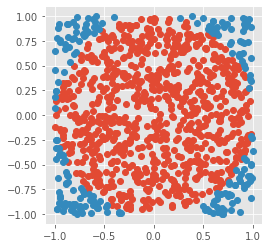

In [3]:
rndm = np.random.RandomState(12345)

N = 1000
x, y = rndm.uniform(low=-1, high=1, size=(2, N))
m = inside(x, y, 1)

fig, ax = plt.subplots()
ax.plot(x[m], y[m], 'o')
ax.plot(x[~m], y[~m], 'o')
ax.set_aspect('equal')


In [4]:
# Now, the estimate for the area is

4 * np.count_nonzero(m) / N

3.176

Note that the result comes as a sum of iid samples, so that the Central Limit Theorem says that the error of the estimate scales as $\propto 1 / \sqrt{N}$.

## II. Integrals of arbitrary functions

To generalize the prescription, let's rewrite it in a slightly more general form. Define 

$$
A(\mathbf{r}) = \left\{
\begin{aligned}
1,& \qquad{\mathbf{r} \in \mathcal{C}}\;, \\
0,& \qquad\text{otherwise}\;.
\end{aligned}
\right.
$$

Then the Buffon's needle prescription in $d$ dimensions is

$$
\frac{\int_\mathcal{D} A(\mathbf{r})\, d^d\mathbf{r}}{\Omega_D} \approx \frac{\sum_{j} A(\mathbf{r}_j)}{\sum_j 1} \;.
$$

Here $\mathbf{r}_j$ are $d$-dimensional vectors drawn from a uniform distribution on $\mathcal{D}$, the unit hypercube in $d$ dimensions.

When written in this form, the prescription is clearly valid for arbitrary $d$ and arbitrary functions $A(\mathbf{r})$.

#### Example: calculate

$$
\iint_\limits{x^2 + y^2 < 1}  e^{-(x^2 + y^2)} \, dx\, dy 
$$

Here $\mathcal{C}$ is the inside of a unit circle, $\{(x, y): x^2 + y^2 < 1 \}$, and $A(x, y) = e^{-(x^2+y^2)}$.

(This example is artificially fine-tuned to ease the comparison with an exact answer, which is $\pi (1 - e^{-1}).$)

In [5]:
def func(x, y):
    r2 = x**2 + y**2
    return np.exp(-r2)

In [6]:
def sample(N, r=1):
    N = int(N)
    x, y = rndm.uniform(low=-1, high=1, size=(2, N))
    accepted = inside(x, y, r)
    denom = accepted.sum()
    return np.sum(func(x[accepted], y[accepted]) / N) * 4, denom

In [7]:
answer = np.pi * (1. - 1./np.e)

np.random.seed(12)

for n in [100, 1000, 10000, 100000, 1e6, 1e7]:
    res = sample(n)
    err = res[0] - answer
    print("%8d  %.7g  %.7g %g" % (n, res[0], answer, err))

     100  2.093158  1.985865 0.107292
    1000  2.019979  1.985865 0.0341134
   10000  1.964416  1.985865 -0.0214495
  100000  1.982801  1.985865 -0.00306389
 1000000  1.987293  1.985865 0.00142807
10000000  1.985898  1.985865 3.31245e-05


To improve convergence, we can either aim to sample the space *more* uniformly, or *less* uniformly.

## III. Quasi-random numbers: Sobol, Halton sequences

Instead of drawing random variates, use special *low-discrepancy sequences* which intend to cover the volume in a uniform manner.

Here's one implementation: In terminal, type 

`pip install sobol_seq --user`

In [8]:
import sobol_seq

In [9]:
sobol_seq.i4_sobol_generate?

In [10]:
sobol_seq.i4_sobol_generate(2, 5)

array([[0.5  , 0.5  ],
       [0.75 , 0.25 ],
       [0.25 , 0.75 ],
       [0.375, 0.375],
       [0.875, 0.875]])

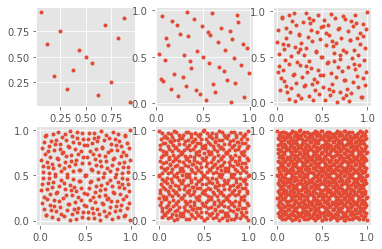

In [11]:
nn = [[15, 51, 151], [251, 521, 1001]]

fig, axx = plt.subplots(2, 3)

for i in (0, 1):
    for j in (0, 1, 2):
        N = nn[i][j]
        ax = axx[i][j]
        x = sobol_seq.i4_sobol_generate(2, N)
        ax.plot(x[:, 0], x[:, 1], 'o', label = "N = %s" % N, ms=4, mec='none')

## IV. Non-uniform distributions

If the integral has sharp peaks, both *Buffon needle II* and quasi-random based methods can be converging slowly.
If the integral is over an infinite range, they simply break down. 

Note that in *Buffon needle II*, the integral in the left-hand side contains the *probability density of a uniform distribution on $\mathcal{D}$*

$$
w_\mathrm{uniform}(\mathbf{r}) = \frac{1}{\Omega_D} d^d\mathbf{r}
$$

This suggests introducing a probability density $w(\mathbf{r})$, and rewriting the target integral via

$$
\int_\mathcal{D} A(\mathbf{r})\,d^d\mathbf{r} \equiv
\int_\mathcal{D} \frac{A(\mathbf{r}) }{ w(\mathbf{r})} \,\color{red}{w(\mathbf{r})\, d^d\mathbf{r}} \;.
$$

Now, if the sequence of $\{ \mathbf{r}_j\}$, $j=1, \dots, N$, *is drawn from the distribution $w(\mathbf{r})$*, then

$$
\int_\mathcal{D} A(\mathbf{r})\,d^d\mathbf{r} \approx \frac{\sum_j A(\mathbf{r}_j)\, /\, w(\mathbf{r}_j)}{\sum_j 1}
$$

#### Example

$$
\int_0^\infty \! x^3 e^{-x} \, dx = \text{?}
$$

Here we take $w(x) \propto e^{-x}$ on $x \in [0, \infty)$, and $A(x) = x^3$

In [12]:
for n in (1e4, 1e5, 1e6, 1e7):
    nn = int(n)
    x = np.random.exponential(size=nn)
    res = (x**3).sum() / n
    print("%8g  %.6g" % (nn, res))

   10000  6.12337
  100000  5.97928
   1e+06  6.00973
   1e+07  6.00365


### How to draw variates given a probability density function?

#### Rejection method

This is basically the Buffon's needle again: Given a p.d.f., $w(\mathbf{r})$, for $d$-dimensional variables, draw $d$ uniform variates, $\mathbf{r}$, and an extra one, $y$, uniform on $[0, 1)$. Compare $y$ and $w(\mathbf{r})$. If $y > w(\mathbf{r})$, *reject* it and draw again. Otherwise, return $\mathbf{r}$. 

#### Inversion method ($d=1$)

Draw $r$ uniform on  $[0, 1)$. Then invert the cumulative distribution function, `cdf`: find $x$ such that 

$$
\mathrm{cdf}(x) = r\;.
$$ 


##### Example

Draw variates from the standard exponential distribution $w(x) \propto \exp(-\lambda x)$ for $x \in [0, \infty)$.

Doing the integrals, we find

$$
\mathrm{cdf}(x) = A \int_0^x\! e^{-\lambda x }\, dx = A \frac{1 - e^{-\lambda x}}{\lambda} \;,
$$

where $A$ is the normalization constant, for which we find $A = \lambda$ since $\mathrm{cdf}(\infty) = 1$.

This way, we find 

$$
x = -\frac{1}{\lambda} \ln(1 - r) \;.
$$

Note that, strictly speaking, we cannot replace $1 - r$ by $r$ since that would be problematic at $r=0$.

/home/alexey/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([1.03209925, 0.92866926, 1.04750372, 0.99028713, 1.02549733,
        1.0232967 , 0.98808649, 0.92646862, 1.0409018 , 0.96387947,
        0.98148457, 0.99028713, 0.97048138, 0.94627436, 0.94407373,
        1.06730946, 1.08491456, 0.99248776, 1.00349095, 1.04970435,
        1.01889542, 0.99028713]),
 array([1.10427324e-04, 4.55517936e-02, 9.09931599e-02, 1.36434526e-01,
        1.81875892e-01, 2.27317259e-01, 2.72758625e-01, 3.18199991e-01,
        3.63641358e-01, 4.09082724e-01, 4.54524090e-01, 4.99965456e-01,
        5.45406823e-01, 5.90848189e-01, 6.36289555e-01, 6.81730922e-01,
        7.27172288e-01, 7.72613654e-01, 8.18055020e-01, 8.63496387e-01,
        9.08937753e-01, 9.54379119e-01, 9.99820486e-01]),
 <a list of 22 Patch objects>)

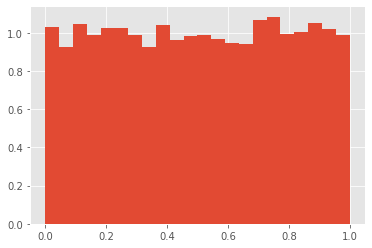

In [13]:
r = np.random.uniform(size=10000)
plt.hist(r, bins='auto', normed=True)

/home/alexey/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(0, 3)

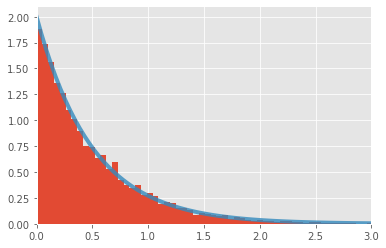

In [14]:
x = -0.5 * np.log(1 - r)
plt.hist(x, bins='auto', normed=True)

xx = np.linspace(x.min(), x.max(), 101)
plt.plot(xx, 2.0 * np.exp(-2*xx), '-', lw=4, alpha=0.8)

plt.xlim([0, 3])

# Excercises

### Excercise 1

Use the Sobol sequence to calculate the value of
$$
\iint\limits_D e^{-(x^2 + y^2)} \, dx\, dy  \;,
$$
where $D$ is the unit square. Compare to the exact answer (which can be expressed in terms of the error function).

In [15]:
import sobol_seq
N = 10**7
seq = sobol_seq.i4_sobol_generate(2, N)

In [38]:
from scipy.integrate import dblquad, tplquad, nquad

In [23]:
def func(x, y):
    return np.e ** -(x ** 2 + y ** 2)

def inside(x, y):
    return x <= 1 and y <= 1

In [29]:
x = np.array(seq[:, 0])
y = np.array(seq[:, 1])

In [31]:
N = 10**7

accepted = np.array([inside(px, py) for px, py in zip(x,y)])

In [34]:
f = [func(px, py) for px, py in zip(x[accepted], y[accepted])]

In [44]:
ans_sobol = np.sum(f) / N

In [46]:
ans, _ = dblquad(func, 0, 1, 0, 1)

In [48]:
ans_sobol - ans

9.732271399887082e-08

Paste the difference between the exact answer and calculated value of the integral in the respective field in Google Form when $N = 10^7$.

### Excercise 2

Generate variates from the distribution $w(x) \propto \sqrt{1 - x^2}$ on $x\in (-1, 1)$ using the rejection method.

In [ ]:
### ....... ENTER YOUR CODE HERE ....... ###

Write a function for finding $\int_{-1}^1 \! \sqrt{1-x^2} \left( 1 - x \right) dx$.

In [51]:
from scipy.integrate import quad

def func(x):
    return np.sqrt(1-x**2) * (1 - x)

quad(func, -1, 1)

(1.5707963266821263, 1.3385506036911465e-09)

Paste the value of the integral in the respective field in Google Form when $N = 10^7$.

### Excercise 3

Generate variates from the distribution $w(x) \propto \exp(-\lambda x)$ on $x \in [a, b]$.

In [13]:
### ....... ENTER YOUR CODE HERE ....... ###

Write a function for finding $\int_0^\infty \! x^3 e^{- \lambda x}$.

In [53]:
from scipy.integrate import quad

def func(x, lambda_=5):
    return x**3 * np.e**(-lambda_*x)

quad(func, 0, np.inf)

(0.009599999999999276, 2.8714814696143335e-09)

Paste the value of the integral in the respective field in Google Form when $N = 10^7$ and $\lambda = 5$.